In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [2]:
# jnp.corrcoef(jnp.mean(traj, axis = 1) - 0.4*ext_connectivity_s[0,:,0], 0.4*ext_connectivity_s[0,:,0])

predictions

In [92]:
# generic numerical function helpers
def num_integral_fct(num_function, iv_resolution, axis =-1):
  sum_left = jnp.sum(num_function[..., :-1], axis = axis) / iv_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = axis) / iv_resolution
  return((sum_left + sum_right) / 2)

# def num_primitive_fct(num_function, baseline_idx, iv_resolution, axis =-1):
#   sum_left = jnp.cumsum(num_function, axis = axis) / iv_resolution
#   sum_right = jnp.cumsum(-num_function[..., ::-1], axis = axis)[..., ::-1] / iv_resolution
#   mean_sum = (sum_left + sum_right) / 2
#   return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def mirror(traj, transformation = lambda iv:iv):
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), traj], axis = -1))

def better_searchsorted(array, value, axis=None, keepdims=False):
  return(jnp.argmax((array >= value) & (jnp.roll(array, 1, axis = axis) < value), axis=axis, keepdims=keepdims))



def potential_s_fct(m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh = "out", 
                    num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = (jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) 
          / num_fct_resolution) # interval > 1
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  def tanh_pri_fct(iv):
    return(jnp.log(jnp.cosh(iv)))
  # potential 1
  potential_1_s = -(m_acov_s ** 2 / 2)
  # potential 2
  if g_tanh == "out":
    factor_out = unscaled_std ** 2
    factor_in = 1
  elif g_tanh == "in":
    factor_out = 1 / unscaled_std ** 2
    factor_in = unscaled_std
  m_var_s = jnp.expand_dims(m_var_s, (1, 2, 3))
  m_acov_s = jnp.expand_dims(m_acov_s, (2, 3))
  potential_2_s = num_integral_fct(
    num_integral_fct(
      tanh_pri_fct(factor_in * (
        jnp.sqrt(m_var_s - m_acov_s) * jnp.expand_dims(iv_s, (0, 1, 2))
        + jnp.sqrt(m_acov_s  + ext_unscaled_std ** 2) * jnp.expand_dims(iv_s, (0, 1, 3))))
      * sta_gau_fct(iv_s), num_fct_resolution) ** 2
    * sta_gau_fct(iv_s), num_fct_resolution) * factor_out
  potential_s = potential_1_s + potential_2_s
  return(potential_s)

def stable_m_var_fct(unscaled_std, ext_unscaled_std, g_tanh = "out", 
                     init_search_window = jnp.array([0,100]), search_frame_n = 20, 
                     search_precision = 0.001, m_acov_frame_n = 20,
                     num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = (jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) 
          / num_fct_resolution) # interval > 1
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2 * jnp.pi))
  def tanh_pri_fct(iv):
    return(jnp.log(jnp.cosh(iv)))
  value_precision = jnp.min(jnp.abs(sta_gau_fct(iv_s)))
  # while
  search_window = init_search_window
  smallest_m_acov_range = 1
  while (search_window[1] - search_window[0]) > jnp.maximum(search_precision,
                                                            smallest_m_acov_range * search_precision):
    m_var_s = (search_window[0] 
               + jnp.arange(search_frame_n) / (search_frame_n + 1) * (search_window[1] - search_window[0]))
    if g_tanh == "out":
      factor_out = unscaled_std ** 2
      factor_in = 1
    elif g_tanh == "in":
      factor_out = 1 / unscaled_std ** 2
      factor_in = unscaled_std
    init_potential_s = (
      - (m_var_s ** 2 / 2)
      + num_integral_fct(
        tanh_pri_fct(factor_in * (
          jnp.sqrt(jnp.expand_dims(m_var_s, 1) + ext_unscaled_std ** 2) * jnp.expand_dims(iv_s, 0))) ** 2
        * sta_gau_fct(iv_s), num_fct_resolution) * factor_out)
    # find peak potentials
    if ext_unscaled_std == 0:
      peak_potential_s = num_integral_fct(
        tanh_pri_fct(factor_in * jnp.sqrt(jnp.expand_dims(m_var_s, 1)) * jnp.expand_dims(iv_s, 0))
        * sta_gau_fct(iv_s), num_fct_resolution) ** 2 * factor_out
      coarse_range_s = 1
      fine_peak_s = jnp.full((search_frame_n, ), 0)
    else:
      coarse_m_acov_s = jnp.arange(m_acov_frame_n) / m_acov_frame_n * jnp.expand_dims(m_var_s, 1)
      coarse_potential_s = potential_s_fct(coarse_m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh, 
                                           num_fct_domain, num_fct_resolution)
      coarse_force_s = -jnp.gradient(coarse_potential_s, axis = 1)
      coarse_peak_idx_s = better_searchsorted(coarse_force_s, 0, axis = 1)
      coarse_range_s = jnp.array(
        [(jnp.max(coarse_potential_s[m_var_idx]) 
          - jnp.min(coarse_potential_s[m_var_idx, coarse_peak_idx_s[m_var_idx]:]))
         for m_var_idx in range(search_frame_n)])
      fine_m_acov_s = (jnp.expand_dims(coarse_m_acov_s[jnp.arange(search_frame_n),
                                                       jnp.maximum(coarse_peak_idx_s - 1, 0)],
                                       1)
                       + (jnp.arange(m_acov_frame_n) / m_acov_frame_n * (1 + 2 / m_acov_frame_n)
                          * jnp.expand_dims(m_var_s / m_acov_frame_n, 1)))
      fine_potential_s = potential_s_fct(fine_m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh, 
                                         num_fct_domain, num_fct_resolution)
      fine_potential_s = ((fine_potential_s - jnp.min(fine_potential_s, axis = 1, keepdims = True))
                            / (jnp.max(fine_potential_s, axis = 1, keepdims = True)
                               - jnp.min(fine_potential_s, axis = 1, keepdims = True)))
      fine_force_s = -jnp.gradient(fine_potential_s, axis = 1)
      fine_peak_idx_s = jnp.maximum(better_searchsorted(fine_force_s, 0, axis = 1), 1) # avoid empty array
      fine_peak_s = jnp.nan_to_num(jnp.minimum(
        jnp.array([jnp.interp(0,
                              fine_force_s[m_var_idx, 
                                           (fine_peak_idx_s[m_var_idx] - 1):(fine_peak_idx_s[m_var_idx] + 1)],
                              fine_m_acov_s[m_var_idx, 
                                            (fine_peak_idx_s[m_var_idx] - 1):(fine_peak_idx_s[m_var_idx] + 1)])
                   for m_var_idx in range(search_frame_n)]),
        m_var_s))
      peak_potential_s = jnp.squeeze(potential_s_fct(jnp.expand_dims(fine_peak_s, 1), m_var_s,
                                                     unscaled_std, ext_unscaled_std, g_tanh, 
                                                     num_fct_domain, num_fct_resolution))
    relative_excess_potential_s = (init_potential_s - peak_potential_s) / coarse_range_s
    m_var_idx = better_searchsorted(-relative_excess_potential_s, 0)
    search_window = jnp.array([m_var_s[jnp.maximum(m_var_idx - 1, 0)], 
                               m_var_s[jnp.maximum(m_var_idx - 1, 0)] 
                               + (m_var_s[1] - m_var_s[0]) * (1 + 2 / search_frame_n)])
    smallest_m_acov_range = jnp.min(m_var_s - fine_peak_s * 0.9)
    # only update solution and proceed if meaningful given error
    if jnp.max(relative_excess_potential_s) - jnp.min(relative_excess_potential_s) > value_precision:
      m_var_with_potential_peak = [m_var_s[m_var_idx], 
                                   jnp.array([fine_peak_s[m_var_idx], 
                                              relative_excess_potential_s[m_var_idx]])]
      output = [m_var_with_potential_peak,
                m_var_s, fine_peak_s, relative_excess_potential_s, init_potential_s, peak_potential_s]
    else:
      search_window = jnp.array([0, 0])
  return(output)

def m_acov_fct(m_var_with_potential_peak, unscaled_std, ext_unscaled_std, g_tanh = "out", 
               m_acov_step_n = 100, sim_len = 100, sim_resolution = 30, connection_pos = 5,
               num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # unpack
  [m_var, potential_peak] = m_var_with_potential_peak
  lower_m_acov = potential_peak[0] * 0.9
  # m_acov_s grid
  m_acov_s = lower_m_acov + jnp.arange(m_acov_step_n + 1) / m_acov_step_n * (m_var - lower_m_acov)
  # potential
  actual_potential = jnp.squeeze(
    potential_s_fct(jnp.expand_dims(m_acov_s, 0), jnp.array([m_var]),
                    unscaled_std, ext_unscaled_std, g_tanh,
                    num_fct_domain, num_fct_resolution))
  actual_potential = actual_potential - jnp.max(actual_potential)
  actual_force = -jnp.gradient(actual_potential) * m_acov_step_n / (m_var - lower_m_acov)
  peak_idx = better_searchsorted(actual_potential,
                                 jnp.max(actual_potential[better_searchsorted(actual_force, 0)
                                                          + jnp.array([-1, 0, 1])]))
  interpolate_right = jnp.arange(m_acov_step_n + 1 - peak_idx) / (m_acov_step_n - peak_idx)
  potential = jnp.concatenate([
    jnp.full((peak_idx, ), 0),
    ((1 - interpolate_right) * (actual_potential[peak_idx:] - actual_potential[peak_idx]))
    + (interpolate_right * (actual_potential[peak_idx:] - actual_potential[-1]))])
  force = -jnp.gradient(potential) * m_acov_step_n / (m_var - lower_m_acov)
  # evolve m_acov
  sim_interval_2d = jnp.array([0, connection_pos])
  sim_interval_1d = jnp.array([connection_pos, sim_len])
  def m_acov_2d_velocity_fct(pos_vel):
    return(jnp.array([pos_vel[1], 
                        jnp.interp(pos_vel[0], m_acov_s, force, left = 0, right = "extrapolate")]))
  def m_acov_1d_velocity_fct(m_acov):
    return(jnp.interp(m_acov, m_acov_s, -jnp.sqrt(jnp.maximum(-2 * potential, 0)), 
                      left = 0, right = "extrapolate"))
  m_acov_2d = traj_initializer(jnp.array([m_var, 0]), sim_interval_2d, sim_resolution)
  m_acov_2d = rk4_ode_solver(m_acov_2d_velocity_fct, lambda time: 0, m_acov_2d, sim_interval_2d[0], sim_resolution)
  m_acov_1d = traj_initializer(m_acov_2d[0,-1], sim_interval_1d, sim_resolution)
  m_acov_1d = rk4_ode_solver(m_acov_1d_velocity_fct, lambda time: 0, m_acov_1d, sim_interval_1d[0], sim_resolution)
  m_acov = jnp.concatenate([jnp.array([m_var]), m_acov_2d[0], m_acov_1d])
  # corresponding times
  acov_lag_s = jnp.arange(sim_len * sim_resolution + 1) / sim_resolution
  return([jnp.array([acov_lag_s, m_acov]), 
          jnp.array([m_acov_s, potential, force, actual_potential, actual_force])])

def all_cov_s_fct(timed_m_acov, unscaled_std, ext_unscaled_std, g_tanh = "out",
              num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = (jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) 
          / num_fct_resolution) # interval > 1
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  def tanh_der_fct(iv):
    return(1 - jnp.tanh(iv) ** 2)
  # mirror to remove ringings
  mirrored_lag_s = mirror(timed_m_acov[0], lambda iv: -iv)
  mirrored_m_acov = mirror(timed_m_acov[1])
  mirrored_n_acov = mirrored_m_acov - mirrored_m_acov[0]
  # ft variables
  ft_n = mirrored_lag_s.shape[0]
  rft_n = jnp.ceil((ft_n + 1) / 2).astype(int)
  interval_len = mirrored_lag_s[-1] - mirrored_lag_s[0]
  rft_omega_s = 2 * jnp.pi * jnp.arange(rft_n) / interval_len
  ft_omega_s = jnp.concatenate([rft_omega_s, -(rft_omega_s[..., 1:][..., ::-1])])
  # ft for acovs # should not use rft since eventually 2d
  m_acov_ft = jnp.fft.fft(mirrored_m_acov)
  n_acov_ft = jnp.fft.fft(mirrored_n_acov)
  r_sq_ft = m_acov_ft * (1+ ft_omega_s**2)
  if g_tanh == "out":
    r_sq_ft = r_sq_ft / unscaled_std ** 2
  r_sq = jnp.fft.irfft(r_sq_ft[:rft_n], ft_n)
  r_acov = r_sq - r_sq[0]
  r_acov_ft = jnp.fft.fft(r_acov)
  # find variance in h_mean_s and gain_mean_s
  if ext_unscaled_std == 0:
    r_var_modulator_sq_mean = 1
    gain_mean_sq_mean = num_integral_fct(
      tanh_der_fct(jnp.sqrt(timed_m_acov[1, 0] + ext_unscaled_std ** 2) * iv_s)
      * sta_gau_fct(iv_s), num_fct_resolution) ** 2
  else:
    h_mean_std_s = iv_s[better_searchsorted(iv_s, 0):]
    h_mean_s = jnp.expand_dims(jnp.sqrt(ext_unscaled_std ** 2 + mirrored_m_acov[0]) * h_mean_std_s, 1)
    n_var = jnp.max(mirrored_n_acov)
    if g_tanh == "out":
      factor_in = 1
    elif g_tanh == "in":
      factor_in = unscaled_std
    r_mean_s = num_integral_fct(
      jnp.tanh(factor_in * (
        jnp.sqrt(n_var) * jnp.expand_dims(iv_s, 0) + h_mean_s))
      * sta_gau_fct(iv_s), num_fct_resolution)
    r_var_s = (
      num_integral_fct(
        jnp.tanh(factor_in * (
          jnp.sqrt(n_var) * jnp.expand_dims(iv_s, 0) + h_mean_s)) ** 2
        * sta_gau_fct(iv_s), num_fct_resolution)
      - r_mean_s ** 2)
    r_var_modulator_s = r_var_s / jnp.max(r_acov)
    r_var_modulator_sq_mean = num_integral_fct(
      mirror(r_var_modulator_s) ** 2
      * sta_gau_fct(mirror(h_mean_std_s, lambda iv: -iv)), num_fct_resolution)
    gain_mean_s = num_integral_fct(
      tanh_der_fct(factor_in * (
        jnp.sqrt(n_var) * jnp.expand_dims(iv_s, 0) + h_mean_s))
      * sta_gau_fct(iv_s), num_fct_resolution)
    gain_mean_sq_mean = num_integral_fct(
      mirror(gain_mean_s) ** 2
      * sta_gau_fct(mirror(h_mean_std_s, lambda iv: -iv)), num_fct_resolution)
  # ccovs
  temp_nn_s = unscaled_std ** 2 * gain_mean_sq_mean
  temp_xx_s = ((1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 1)))
               * (1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 0))))
  n_ccov_sq_ft = ((((1 + r_var_modulator_sq_mean) * jnp.abs(temp_xx_s) ** 2 - temp_nn_s ** 2)
                   / jnp.abs(temp_xx_s - temp_nn_s) ** 2 
                   - 1)
                  * jnp.expand_dims(n_acov_ft, 1) * jnp.expand_dims(n_acov_ft, 0))
  r_ccov_sq_ft = ((jnp.abs(temp_xx_s / (temp_xx_s - temp_nn_s)) ** 2 - 1) * r_var_modulator_sq_mean
                  * jnp.expand_dims(r_acov_ft, 1) * jnp.expand_dims(r_acov_ft, 0))
  n_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(n_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  r_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(r_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  # r_sq = jnp.real(jnp.fft.ifft(r_sq_ft, ft_n))
  # r_acov = jnp.real(jnp.fft.ifft(r_acov_ft, ft_n))
  # n_ccov_sq = jnp.real(jnp.fft.ifft2(n_ccov_sq_ft, (ft_n,ft_n)))
  # r_ccov_sq = jnp.real(jnp.fft.ifft2(r_ccov_sq_ft, (ft_n,ft_n)))
  return([jnp.array([mirrored_lag_s,
                     mirrored_m_acov, mirrored_n_acov,
                     r_sq, r_acov]),
          jnp.array([n_ccov_sq, r_ccov_sq]), 
          r_var_modulator_sq_mean])

def prediction_s_fct(all_cov_s, rescaled_relative_lag_s, window_len_s, part_n_s,
                     num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = (jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) 
          / num_fct_resolution)
  long_num_fct_domain_len = jnp.ceil(window_len_s[-1]* 5).astype(int)
  long_iv_s = (jnp.arange(long_num_fct_domain_len * num_fct_resolution) / num_fct_resolution
               - long_num_fct_domain_len / 2)
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  # unpack and turn into functions
  [acov_s, ccov_sq_s, r_var_modulator_sq_mean] = all_cov_s
  [lag_s, m_acov, n_acov, r_sq, r_acov] = acov_s
  [n_ccov_sq, r_ccov_sq] = ccov_sq_s
  def n_acov_fct(iv):
    return(jnp.interp(iv, lag_s, n_acov, left = 0, right = 0))
  def n_ccov_sq_main_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",n_ccov_sq), left = 0, right = 0))
  def n_ccov_sq_off_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",n_ccov_sq[:,::-1]), left = 0, right = 0))
  def r_acov_fct(iv):
    return(jnp.interp(iv, lag_s, r_acov, left = 0, right = 0))
  def r_ccov_sq_main_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",r_ccov_sq), left = 0, right = 0))
  def r_ccov_sq_off_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",r_ccov_sq[:,::-1]), left = 0, right = 0))
  # local_cvar_sq
  def local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                          rescaled_relative_lag_s, window_len_s, part_n_s):
    rescaled_relative_lag_s = jnp.expand_dims(rescaled_relative_lag_s, 1)
    std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2), (1, 2))
    part_n_s = jnp.expand_dims(part_n_s, (1,2))
    filter_s = sta_gau_fct(long_iv_s / std_s - rescaled_relative_lag_s * jnp.sqrt(2)) / std_s
    iiii = r_var_modulator_sq_mean * (acov_fct(0) ** 2 
                                      + num_integral_fct(2 * acov_fct(long_iv_s) ** 2
                                                         * filter_s, num_fct_resolution))
    iijj = (acov_fct(0) ** 2
            + 2 / part_n_s * num_integral_fct(ccov_sq_main_fct(long_iv_s)
                                              * filter_s, num_fct_resolution))
    ijij = (ccov_sq_off_fct(0) / part_n_s
            + num_integral_fct(acov_fct(long_iv_s) **2
                               * filter_s, num_fct_resolution)
            +  1 / part_n_s * num_integral_fct(ccov_sq_off_fct(long_iv_s)
                                               * filter_s, num_fct_resolution))
    return([iiii, iijj, ijij])
  # predictions for h or r
  def pr_os_s(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct, 
              rescaled_relative_lag_s, window_len_s, part_n_s):
    [local_cvar_sq_iiii, local_cvar_sq_iijj, local_cvar_sq_ijij
     ] = local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                             jnp.concatenate([jnp.array([0]), rescaled_relative_lag_s]),
                             window_len_s, part_n_s)
    part_n_s = jnp.expand_dims(part_n_s, (1, 2))
    # pr, os(tau), os T:inf
    return([(local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_iijj[..., 0:1])
            / (part_n_s * (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1])),
            (local_cvar_sq_iiii[..., 1:] + (part_n_s - 1) * local_cvar_sq_ijij[..., 1:])
            / (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1]),
            jnp.sqrt(
              (r_var_modulator_sq_mean * acov_fct(0) ** 2 + (1 - 1 / part_n_s) * ccov_sq_main_fct(0))
              / (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1]))])
  n_prediction_s = pr_os_s(n_acov_fct, n_ccov_sq_main_fct, n_ccov_sq_off_fct,
                           rescaled_relative_lag_s, window_len_s, part_n_s)
  r_prediction_s = pr_os_s(r_acov_fct, r_ccov_sq_main_fct, r_ccov_sq_off_fct,
                           rescaled_relative_lag_s, window_len_s, part_n_s)
  return([n_prediction_s, r_prediction_s])

plot

In [3]:
color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']
activity_type_s = ["h (or n)", "r"]

In [ ]:
ext_unscaled_std_s = jnp.array([0, 0.6, 1.2, 1.8, 2.4])
rescaled_relative_lag_s = jnp.arange(30) / 30 * 4
part_n_s = jnp.array([500, 1000, 2000])
window_len_s = jnp.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560])

stable_m_var_s = [0 for ext_unscaled_std in ext_unscaled_std_s]
m_acov_s = [0 for ext_unscaled_std in ext_unscaled_std_s]
all_cov_s = [0 for ext_unscaled_std in ext_unscaled_std_s]
prediction_s = [0 for ext_unscaled_std in ext_unscaled_std_s]

for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
  start_time = time.time()
  stable_m_var_s[ext_unscaled_std_idx] = stable_m_var_fct(4, ext_unscaled_std_s[ext_unscaled_std_idx])[0]
  m_acov_s[ext_unscaled_std_idx] = m_acov_fct(stable_m_var_s[ext_unscaled_std_idx], 
                                            4, ext_unscaled_std_s[ext_unscaled_std_idx])[0]
  all_cov_s[ext_unscaled_std_idx] = all_cov_s_fct(m_acov_s[ext_unscaled_std_idx], 
                                                  4, ext_unscaled_std_s[ext_unscaled_std_idx])
  prediction_s[ext_unscaled_std_idx] = prediction_s_fct(all_cov_s[ext_unscaled_std_idx], 
                                                        rescaled_relative_lag_s, window_len_s, part_n_s)
  end_time = time.time()
  print(end_time - start_time)

4.561279058456421
6.150163173675537
5.816350936889648


In [67]:
print(jnp.max(all_cov_s[-1][0][4]), jnp.max(all_cov_s[-1][2]))

0.25750184 1.773


(0.0, 30.0)

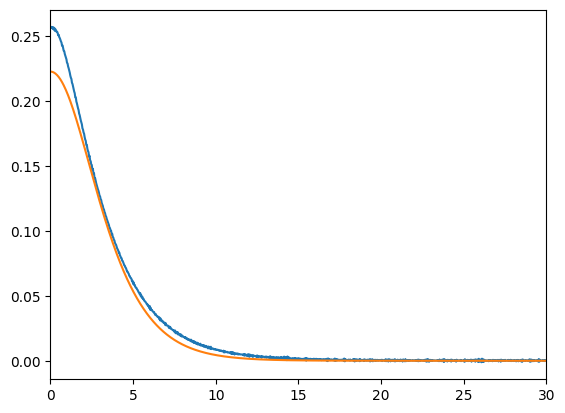

In [66]:
plt.plot(all_cov_s[-1][0][0], 
         all_cov_s[-1][0][2 * (1 + 1)])
plt.plot(all_cov_s[-1][0][0], 
         jnp.einsum("ii->i",all_cov_s[-1][1][1]))
plt.xlim(0,30)

(0.0, 30.0)

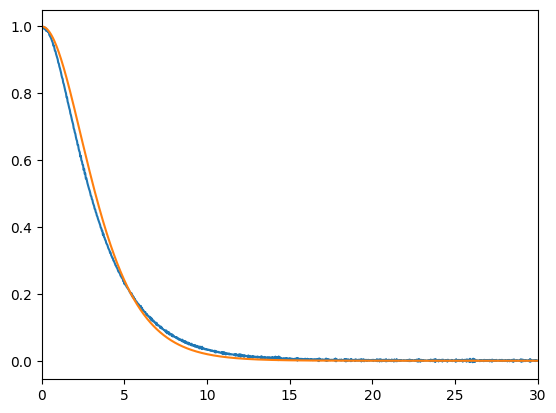

In [69]:
plt.plot(all_cov_s[-1][0][0], 
         all_cov_s[-1][0][2 * (1 + 1)] / jnp.max(all_cov_s[-1][0][2 * (1 + 1)]))
plt.plot(all_cov_s[-1][0][0], 
         jnp.einsum("ii->i",all_cov_s[-1][1][1]) / jnp.max(all_cov_s[-1][1][1]))
plt.xlim(0,30)

In [ ]:
# acov ccov
[fig, subfig_s] = plt.subplots(2, 2, figsize = (15,7), squeeze = False)

for activity_type_idx in range(2):
  for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
    subfig_s[0, activity_type_idx].plot(all_cov_s[ext_unscaled_std_idx][0][0], 
                                        all_cov_s[ext_unscaled_std_idx][0][2 * (activity_type_idx + 1)], 
                                        label = ext_unscaled_std_s[ext_unscaled_std_idx])
    subfig_s[1, activity_type_idx].plot(all_cov_s[ext_unscaled_std_idx][0][0], 
                                        jnp.einsum("ii->i",all_cov_s[ext_unscaled_std_idx][1][activity_type_idx]))
subfig_s[0, 0].legend()
subfig_s[0, 0].set(title = activity_type_s[0], ylabel = "acov")
subfig_s[0, 1].set(title = activity_type_s[1])
subfig_s[1, 0].set(ylabel = "ccov")
fig.text(0.5, 0.04, "tau", ha="center")

In [ ]:
[fig, subfig_s] = plt.subplots(2, 2, figsize = (15,7), squeeze = False)

for activity_type_idx in range(2):
  for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
    for part_n_idx in range(len(part_n_s)):
      subfig_s[activity_type_idx, 0].plot(window_len_s / part_n_s[part_n_idx], 
                          prediction_s[ext_unscaled_std_idx][activity_type_idx][0][part_n_idx, :, 0], 
                          color = color_s[ext_unscaled_std_idx], 
                          label = ("{0:.1f}".format(ext_unscaled_std_s[ext_unscaled_std_idx])
                                   if part_n_idx == 0 else ""))

for activity_type_idx in range(2):
  for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
    for part_n_idx in range(len(part_n_s)):
      subfig_s[activity_type_idx, 1].plot(window_len_s / part_n_s[part_n_idx], 
                          prediction_s[ext_unscaled_std_idx][activity_type_idx][2][part_n_idx, :, 0], 
                          color = color_s[ext_unscaled_std_idx])

subfig_s[0, 0].legend()
subfig_s[0, 0].set(title = "pr_T", ylabel = activity_type_s[0], xscale = "log")
subfig_s[0, 1].set(title = "os_T:inf", xscale = "log")
subfig_s[1, 0].set(ylabel = activity_type_s[1], xscale = "log")
subfig_s[1, 1].set(xscale = "log")
fig.text(0.5, 0.04, "T/N", ha = "center")

In [ ]:
legend_type_s = jnp.sort(jnp.unique(part_n_s / jnp.expand_dims(window_len_s, 1)))

[fig, subfig_s] = plt.subplots(len(ext_unscaled_std_s), 2, figsize = (15,15), squeeze = False)

for activity_type_idx in range(2):
  for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
    subfig_s[ext_unscaled_std_idx, activity_type_idx].set(xlim = (0, 4), ylim = (0,1))
    subfig_s[ext_unscaled_std_idx, 0].set(ylabel = "{0:.1f}".format(ext_unscaled_std_s[ext_unscaled_std_idx]))
    for part_n_idx in range(len(part_n_s)):
      for window_len_idx in range(len(window_len_s)):
        subfig_s[ext_unscaled_std_idx, activity_type_idx
        ].plot(rescaled_relative_lag_s, 
               prediction_s[ext_unscaled_std_idx][activity_type_idx][1][part_n_idx, window_len_idx, :], 
               color = color_s[better_searchsorted(
                 legend_type_s, part_n_s[part_n_idx] / window_len_s[window_len_idx]) % len(color_s)], 
               label = ("{0}/{1}".format(part_n_s[part_n_idx], window_len_s[window_len_idx]) 
                        if ext_unscaled_std_idx + activity_type_idx == 0 else ""))

fig.legend(loc = "outside right")
subfig_s[0, 0].set(title = "os_T (tau), " + activity_type_s[0])
subfig_s[0, 1].set(title = "os_T (tau), " + activity_type_s[1])
fig.text(0.5, 0.04, "tau/T", ha = "center")

compare

In [ ]:
# numerics
[part_n, sim_window_len_s, samp_sep_s, 
 h_mean_var_s_free, pr_s_free, tr_s_free, os_s_free, lagged_os_s_free
] = load_as_list("sim_free.npz")
[part_n, sim_window_len_s, samp_sep_s, 
 h_mean_var_s, pr_s, tr_s, os_s, lagged_os_s
] = load_as_list("sim.npz")

def val_stat_s_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0, 2, 3, 4, 6))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

val_stat_s = [val_stat_s_fct([h_mean_var_s_free, h_mean_var_s]), 
              val_stat_s_fct([pr_s_free, pr_s]), 
              val_stat_s_fct([tr_s_free, tr_s]), 
              val_stat_s_fct([os_s_free, os_s])]

# analytics
sim_part_n_idx = better_searchsorted(part_n_s, part_n)

# plot
[fig, subfig_s] = plt.subplots(2, 2, figsize = (20,7), squeeze = False)

for ext_idx in range(len(ext_unscaled_std_s)):
  subfig_s[0, 0].axhline(jnp.min(all_cov_s[ext_idx][0][3]),
                         label = "A " + str(ext_unscaled_std_s[ext_idx]), 
                         color = color_s[ext_idx])
  subfig_s[0, 1].plot(window_len_s / part_n_s[sim_part_n_idx], prediction_s[ext_idx][1][0][sim_part_n_idx, :, 0], 
                      color = color_s[ext_idx])
  subfig_s[1, 0].axhline(jnp.max(all_cov_s[ext_idx][0][4]), 
                         color = color_s[ext_idx])
  subfig_s[1, 1].plot(window_len_s / part_n_s[sim_part_n_idx], prediction_s[ext_idx][1][2][sim_part_n_idx, :, 0], 
                      color = color_s[ext_idx])
  for stat_idx in range(4):
    plot_idx = jnp.unravel_index(stat_idx, (2, 2))
    subfig_s[plot_idx].errorbar(sim_window_len_s / part_n,
                                val_stat_s[stat_idx][0][ext_idx],
                                yerr = val_stat_s[stat_idx][1][ext_idx],
                                capsize = 2, label = ("N " + str(ext_unscaled_std_s[ext_idx]) 
                                                      if stat_idx == 0 else ""), 
                                color = color_s[ext_idx],
                                linestyle = "--", marker = ".")
subfig_s[0, 0].set(ylabel = "<h> var")
subfig_s[0, 1].set(ylabel = "pr_T")
subfig_s[1, 0].set(ylabel = "tr_T/N")
subfig_s[1, 1].set(ylabel = "os_T:inf")
for stat_idx in range(4):
  plot_idx = jnp.unravel_index(stat_idx, (2, 2))
  subfig_s[plot_idx].set(xscale = "log", 
                         xticks = sim_window_len_s / part_n, xticklabels = sim_window_len_s / part_n)
  subfig_s[plot_idx].grid()
fig.text(0.5, 0.04, "T/N", ha = "center")
fig.legend(loc = "outside right")

In [ ]:
# numerics
def lagged_val_stat_s_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0, 2, 3, 4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

lagged_val_stat_s = lagged_val_stat_s_fct([lagged_os_s_free, lagged_os_s])


# plot
[fig, subfig_s] = plt.subplots(len(ext_unscaled_std_s), 1, figsize = (15,15), squeeze = False)

for ext_unscaled_std_idx in range(len(ext_unscaled_std_s)):
  for sim_window_len_idx in range(len(sim_window_len_s)):
    window_len_idx = better_searchsorted(window_len_s, sim_window_len_s[sim_window_len_idx])
    subfig_s[ext_unscaled_std_idx, 0
    ].plot(rescaled_relative_lag_s, 
           prediction_s[ext_unscaled_std_idx][1][1][sim_part_n_idx, window_len_idx, :], 
           color = color_s[window_len_idx], 
           label = ("A T = {:.2f}N".format(window_len_s[window_len_idx] / part_n_s[sim_part_n_idx]) 
                    if ext_unscaled_std_idx == 0 else ""))
    subfig_s[ext_unscaled_std_idx, 0
    ].errorbar(samp_sep_s  / sim_window_len_s[sim_window_len_idx], lagged_val_stat_s[0][ext_unscaled_std_idx, sim_window_len_idx], 
                          yerr = lagged_val_stat_s[1][ext_unscaled_std_idx, sim_window_len_idx], capsize = 4, 
                          label = ("N T = {:.2f}N".format(window_len_s[window_len_idx] / part_n_s[sim_part_n_idx]) 
                    if ext_unscaled_std_idx == 0 else ""), 
                          color = color_s[window_len_idx],
                                   linestyle = "", marker = ".")
  subfig_s[ext_unscaled_std_idx, 0].set(xlim = (0, 4), ylim = (0,1), 
                                        ylabel = "{0:.1f}".format(ext_unscaled_std_s[ext_unscaled_std_idx]))
fig.legend(loc = "outside right")
subfig_s[0, 0].set(title = "os_T (tau)")
fig.text(0.5, 0.04, "tau/T", ha = "center")

for subfig in subfig_s.flatten():
  subfig.grid()

appendix

Text(0.5, 0.04, '1.2')

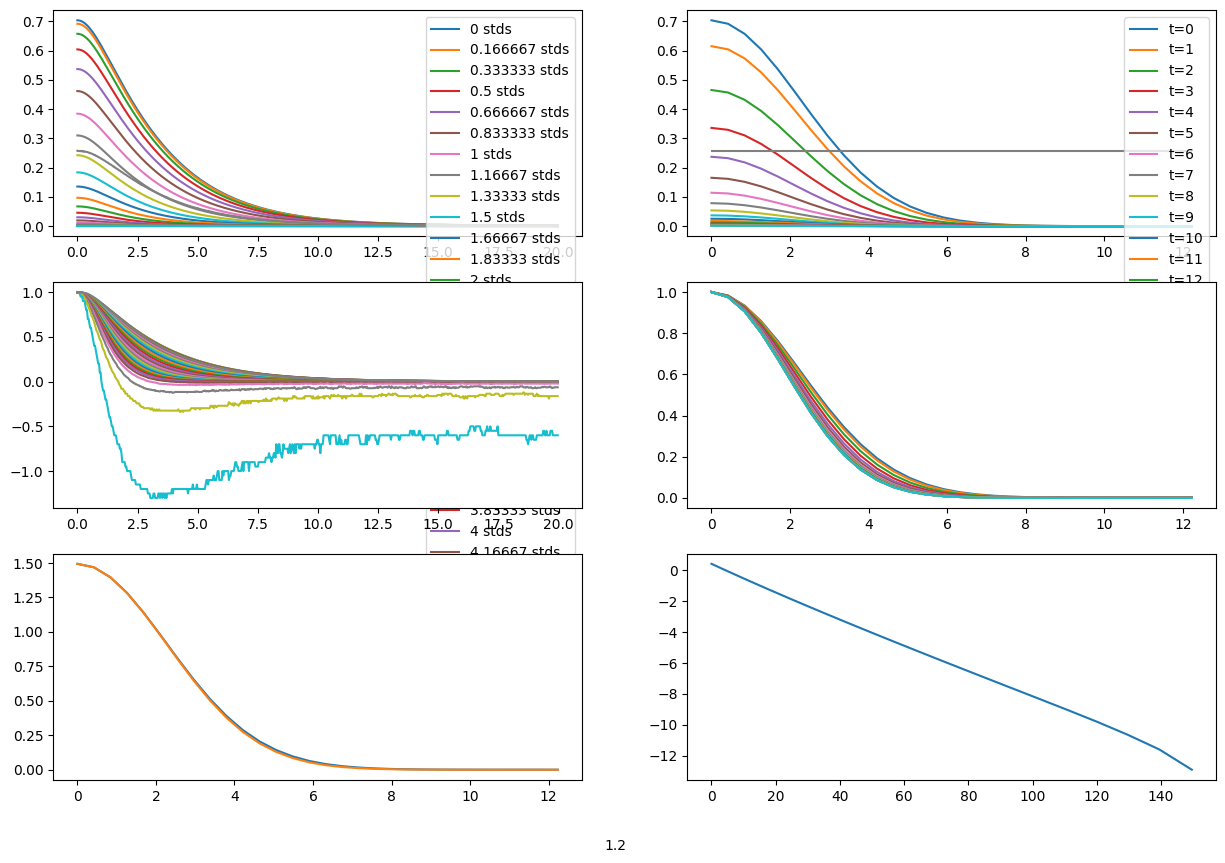

In [89]:
# argument for r_acov at different means is the same up to scaling
def r_acov_s_fct(n_acov, h_mean_s, g_tanh = "out", 
                 num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = (jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) 
          / num_fct_resolution) # interval > 1
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  def tanh_der_fct(iv):
    return(1 - jnp.tanh(iv) ** 2)
  # prep
  n_var = n_acov[0]
  h_mean_s = jnp.expand_dims(h_mean_s, (1, 2, 3))
  n_acov = jnp.expand_dims(n_acov, (0, 2, 3))
  if g_tanh == "out":
    factor_in = 1
  elif g_tanh == "in":
    factor_in = unscaled_std
  # r_acov_s
  mean_gain_s = jnp.squeeze(
    num_integral_fct(
      tanh_der_fct(factor_in * (
        jnp.sqrt(n_var) * jnp.expand_dims(iv_s, (0, 1, 2))
        + h_mean_s))
      * sta_gau_fct(iv_s), num_fct_resolution), axis = 2)
  r_mean_s = jnp.squeeze(
    num_integral_fct(
      jnp.tanh(factor_in * (
        jnp.sqrt(n_var) * jnp.expand_dims(iv_s, (0, 1, 2))
        + h_mean_s))
      * sta_gau_fct(iv_s), num_fct_resolution), axis = 2)
  r_acov_s = (
    num_integral_fct(
      num_integral_fct(
        jnp.tanh(factor_in * (
          jnp.sqrt(n_var - n_acov) * jnp.expand_dims(iv_s, (0, 1, 2))
          + jnp.sqrt(n_acov) * jnp.expand_dims(iv_s, (0, 1, 3))
          + h_mean_s))
        * sta_gau_fct(iv_s), num_fct_resolution) ** 2
      * sta_gau_fct(iv_s), num_fct_resolution)
    - r_mean_s ** 2)
  return([r_acov_s, r_mean_s, mean_gain_s])

test_ext_unscaled_std_idx = 2
test_h_mean_std_range = 5
test_frame_n = 20 * 30
test_h_mean_n = 30

test_m_mean_var = m_acov_s[test_ext_unscaled_std_idx][1, -1]
test_h_mean_std_s = jnp.arange(test_h_mean_n) / test_h_mean_n * test_h_mean_std_range # can - test_h_mean_n // 2 / test_h_mean_n to verify even
test_h_mean_s = (jnp.sqrt(ext_unscaled_std_s[test_ext_unscaled_std_idx] ** 2 + test_m_mean_var)
                 * test_h_mean_std_s)
test_n_acov = m_acov_s[test_ext_unscaled_std_idx][1, :test_frame_n] - test_m_mean_var
[test_r_acov_s, test_r_mean_s, test_mean_gain_s] = r_acov_s_fct(test_n_acov, test_h_mean_s)


[fig, subfig_s] = plt.subplots(3, 2, figsize = (15,10), squeeze = False)
for test_h_mean_idx in range(test_h_mean_n):
  subfig_s[0, 0].plot(m_acov_s[test_ext_unscaled_std_idx][0, :test_frame_n], 
                      test_r_acov_s[test_h_mean_idx], 
                      label = "{:n} stds".format(test_h_mean_std_s[test_h_mean_idx]))
subfig_s[0, 0].plot(m_acov_s[test_ext_unscaled_std_idx][0, :test_frame_n], 
                    all_cov_s[ext_unscaled_std_idx][0][4][100*30:100*30+test_frame_n], 
                    label = "mean", color = "gray")
subfig_s[0, 0].legend()
for test_step_idx in range(test_frame_n // 30):
  subfig_s[0, 1].plot(test_h_mean_s, 
                      test_r_acov_s[:, test_step_idx * 30], 
                      label = "t={:n}".format(test_step_idx))
subfig_s[0, 1].hlines(all_cov_s[ext_unscaled_std_idx][0][4][100*30], 0, jnp.max(test_h_mean_s), color = "gray")
subfig_s[0, 1].legend()
for test_h_mean_idx in range(test_h_mean_n):
  subfig_s[1, 0].plot(m_acov_s[test_ext_unscaled_std_idx][0, :test_frame_n], 
                      test_r_acov_s[test_h_mean_idx] / test_r_acov_s[test_h_mean_idx, 0], 
                      label = "{:n} stds".format(test_h_mean_std_s[test_h_mean_idx]))
subfig_s[1, 0].plot(m_acov_s[test_ext_unscaled_std_idx][0, :test_frame_n], 
                    all_cov_s[test_ext_unscaled_std_idx][0][4][2999:2999+test_frame_n] 
                    / all_cov_s[test_ext_unscaled_std_idx][0][4][2999], 
                    label = "mean", color = "gray")
for test_step_idx in range(test_frame_n // 30):
  subfig_s[1, 1].plot(test_h_mean_s, 
                      test_r_acov_s[:, test_step_idx * 30] / test_r_acov_s[0, test_step_idx * 30], 
                      label = "t={:n}".format(test_step_idx))
subfig_s[2, 0].plot(test_h_mean_s, test_r_acov_s[:, 0] / all_cov_s[test_ext_unscaled_std_idx][0][4][2999])
subfig_s[2, 0].plot(test_h_mean_s, 
                    jnp.exp(test_h_mean_s ** 2 
                            * ((jnp.log(test_r_acov_s[1, 0] / all_cov_s[test_ext_unscaled_std_idx][0][4][2999]) 
                                - jnp.log(test_r_acov_s[0, 0] / all_cov_s[test_ext_unscaled_std_idx][0][4][2999]))
                               / test_h_mean_s[1] ** 2)) 
                    * test_r_acov_s[0, 0] / all_cov_s[test_ext_unscaled_std_idx][0][4][2999])
subfig_s[2, 1].plot(test_h_mean_s ** 2, 
                    jnp.log(test_r_acov_s[:, 0] / all_cov_s[test_ext_unscaled_std_idx][0][4][2999]))
fig.text(0.5, 0.04, ext_unscaled_std_s[test_ext_unscaled_std_idx], ha = "center")

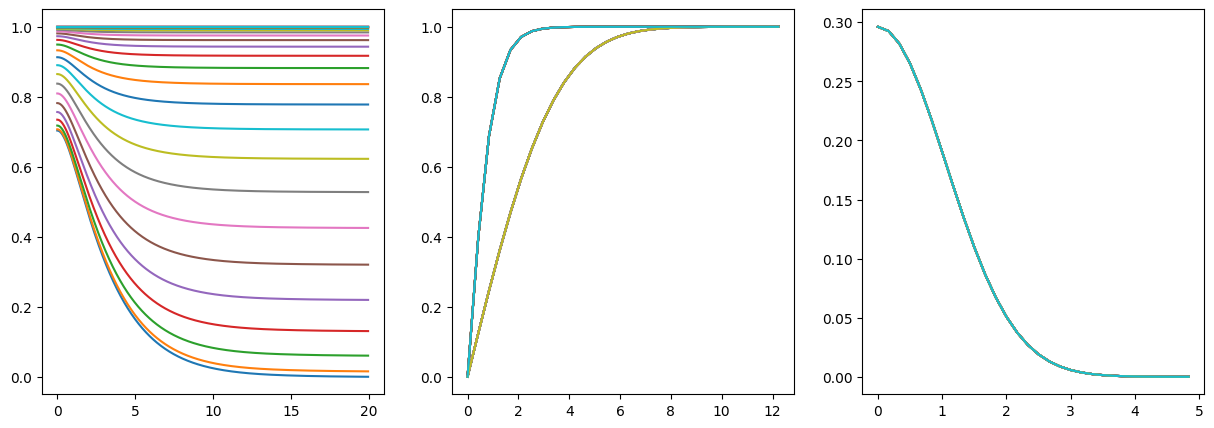

In [90]:
[fig, subfig_s] = plt.subplots(1, 3, figsize = (15,5), squeeze = False)
for test_h_mean_idx in range(test_h_mean_n):
  subfig_s[0, 0].plot(m_acov_s[test_ext_unscaled_std_idx][0, :test_frame_n], 
                      test_r_acov_s[test_h_mean_idx]+test_r_mean_s[test_h_mean_idx]**2, 
                      label = "{:n} stds".format(test_h_mean_std_s[test_h_mean_idx]))
for test_step_idx in range(test_frame_n // 30):
  subfig_s[0, 1].plot(test_h_mean_s, 
                      test_r_mean_s[:, test_step_idx * 30], 
                      label = "t={:n}".format(test_step_idx))
  subfig_s[0, 1].plot(test_h_mean_s, 
                      jnp.tanh(test_h_mean_s))
for test_step_idx in range(test_frame_n // 30):
  subfig_s[0, 2].plot(test_h_mean_std_s, 
                      test_mean_gain_s[:, test_step_idx * 30], 
                      label = "t={:n}".format(test_step_idx))


In [91]:
foo = jnp.exp(- test_h_mean_std_s ** 2 / 2)
foo = foo / jnp.sum(foo)
print(jnp.sum(test_r_acov_s[:, 0] * foo), all_cov_s[test_ext_unscaled_std_idx][0][4][2999])
print(jnp.sum(test_r_mean_s[:, 0] ** 2 * foo), all_cov_s[test_ext_unscaled_std_idx][0][3][0])

0.48819265 0.47105944
0.29100278 0.3102194


trivial PR_T (doesn't contribute much, replace with an argument)

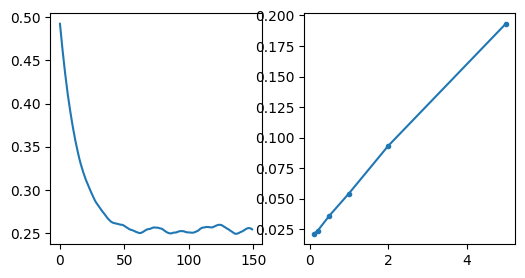

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 50
flip_n = 20
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.array([0.1, 0.2,0.5,1,2,5])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')